## Evaluations

### Imports

In [1]:
import os
import sys
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import files.RNN as rec
import matplotlib.pyplot as plt

from files.Utils import Utils
# from Models import ProgCNN
from torchvision import transforms
from files.FeatureExtractors import AudioFeatureExtractor
from files.Datasets import SnippetProgDataset
from torch.utils.data import DataLoader
from torchsummary import summary
from files.songList import load_csv, generate_table
from torch.utils.tensorboard import SummaryWriter

### Loading Songs and Dataset

In [2]:
test_songs = load_csv("test_audio_files.csv")

In [3]:
CLASS_NAMES = ['Non-Prog', 'Prog']
SAMPLING_RATE = 11025
SNIPPET_LENGTH = 10

In [4]:
transform = transforms.Compose([
        AudioFeatureExtractor(sr = SAMPLING_RATE),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.0], std = [1.0])
])

In [5]:
test_dataset = Utils.getTestData(SnippetProgDataset, test_songs, transform, getNew=False, saveData=False)

### Device

In [6]:
writer = None
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
torch.cuda.empty_cache()
print(f"The current device used is {device}")

The current device used is cuda


### Model Loading

In [7]:
class ProgCNN(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 1, dropout: float = 0.2):
        super(ProgCNN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv1 = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size = 3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.dropout = nn.Dropout(dropout)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 3, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2)
        )

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 2 * 4, 512),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU()
        )

        self.fc4 = nn.Sequential(
            nn.Linear(64, self.out_channels),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.sigmoid(self.fc4(x))
        return x

In [8]:
BATCH_SIZE = 32
EXPERIMENT = 5
loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, num_workers = 2, shuffle = True)
loss_fn = nn.BCELoss()
model = ProgCNN().to(device)
model_params = torch.load(f"models/model_exp{EXPERIMENT}.pth")
model.load_state_dict(model_params["model_state_dict"])

<All keys matched successfully>

### Helper Function

In [9]:
def evaluate(loader, model):
    model.eval()
    loss = 0.0
    correct = 0
    predictions_dict = {}
    results = {}
    with torch.no_grad():
        for inputs, labels, metadata in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = inputs.float(), labels.float()
            
            outputs = model(inputs).reshape(-1)
            loss += loss_fn(outputs, labels).item()
            predictions = (outputs > 0.5).long().reshape(-1)
            correct += (predictions == labels).sum()
            
            results = Utils.getConfusionMatrix(results, predictions.cpu().detach().numpy(), labels.cpu().detach().numpy())
            Utils.updateSongDict(predictions_dict, metadata, outputs)
            
        loss /= len(loader)
        accuracy = 100. * correct / len(loader.dataset)
    print(f"Test Evalutaion: Loss: {loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({accuracy:.2f}%)")
    return predictions_dict, results

def eval_score(loader, model):
    model.eval()
    predictions_dict = {}
    with torch.no_grad():
        for inputs, labels, metadata in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = inputs.float(), labels.float()
            outputs = model(inputs).reshape(-1)            
            Utils.updateSongDict(predictions_dict, metadata, outputs)
    return predictions_dict

### Evaluate over snippets

/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/anish/miniconda3/envs/prog/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Test Evalutaion: Loss: 0.5717, Accuracy: 8480/11529 (73.55%)
Non Prog Accuracy 55.76%
Prog Accuracy 84.22%
Non Prog Accuracy 55.76%
Prog Accuracy 84.22%


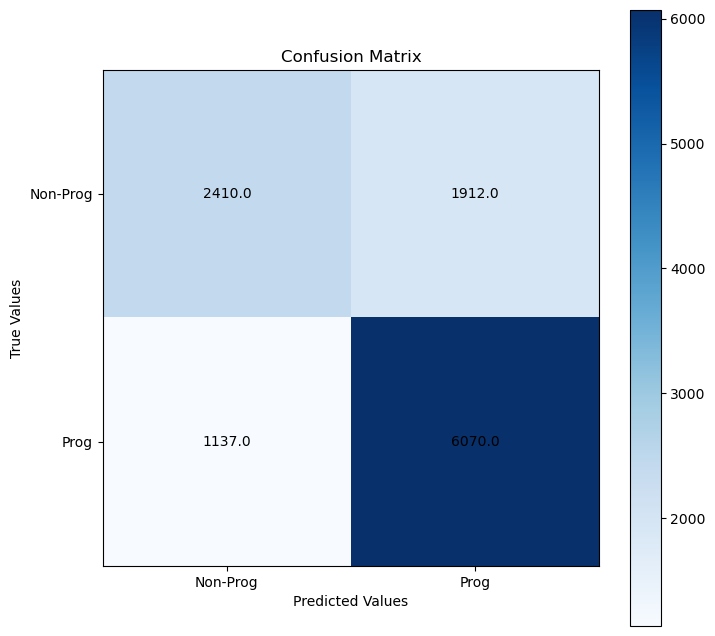

In [10]:
test_dict, results = evaluate(loader, model)
for key in results:
    for class_name in CLASS_NAMES:
        if class_name in key:
            print(key, f"{results[key]:.2f}%")

Utils.getClassAccuracies(results, CLASS_NAMES)
Utils.plot_confusion_matrix(results["conf_matrix"], CLASS_NAMES)

### Voting over songs

1)	03 Nightmares On Wax - Pipes Honour.mp3	 1:0	0.75
2)	05. Ancestress (feat. Sindri Eldon).mp3	 1:0	0.49
3)	13 - Neodammerung.mp3	 1:0	0.55
4)	09-the_strokes-ode_to_the_mets.mp3	 1:0	0.62
5)	12-modest_mouse-spitting_venom.mp3	 1:0	0.67
6)	Thrak-King Crimson-06-THRAK.mp3	 0:1	0.45
7)	01 - Nothing At Best.mp3	 0:1	0.53
8)	03 Boys Don't Cry.mp3	 1:0	0.55
9)	03-Sweet Blindness.mp3	 1:0	0.56
10)	05-miles_runs_the_voodoo_down_320_lame_cbr.mp3	 1:0	0.67
11)	01 the american metaphysical circus.mp3	 1:0	0.6
12)	03 Katy Song.mp3	 1:0	0.51
13)	15 - Mussorgsky - Pictures at an Exhibition (orch. Ravel)- The Great Gate at Kiev.flac	 1:0	0.61
14)	02 - Sigur Rós - Svefn-G-Englar.mp3	 1:0	0.65
15)	02-tears_for_fears-the_tipping_point-68bb3466.mp3	 1:0	0.53
16)	09 - Intimate Grandeur.mp3	 1:0	0.67
17)	The Power To Believe-King Crimson-08-Dangerous Curves.mp3	 0:1	0.32
18)	03. Tessellate.mp3	 1:0	0.74
19)	20. De La Soul - Me Myself And I.mp3	 1:0	0.5
20)	04 Boy In The Moon.mp3	 1:0	0.54
21)	John William

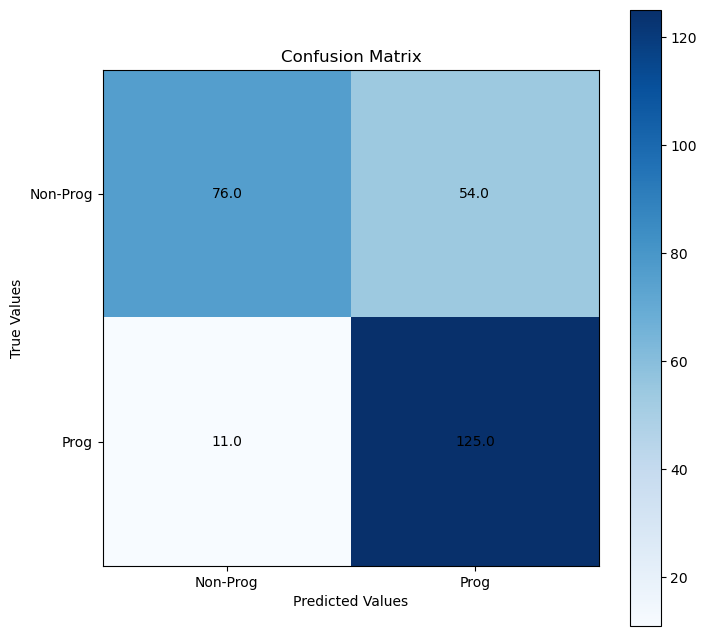

In [11]:
test_songs_probabilities, test_labels = rec.prepareSongData(test_dict, test_songs)
correct = 0
predictions = []
mis_classified_count = 0
songs_table = []
with torch.no_grad():
    for name, song, label in zip(test_dict.keys(), test_songs_probabilities, test_labels):
        pred = Utils.getSongPredictions([(snip > 0.5).long().item() for snip in song.view(-1)])
        correct += (pred == label.item())
        predictions.append(pred)
        if pred != label:
            mis_classified_count += 1
            print(f"{mis_classified_count})\t{name}\t {pred}:{label.item()}\t{round(torch.mean(song.view(-1)).item(), 2)}")
            songs_table.append([name, int(label.item()), pred, round(torch.mean(song.view(-1)).item(), 2)])
    accuracy = 100. * (correct / len(test_songs_probabilities))
    result = Utils.getConfusionMatrix({}, predictions, test_labels)
generate_table(f"voting_eval_exp{EXPERIMENT}", songs_table)
print(f"Accuracy after Voting: {accuracy:.2f}%")
Utils.getClassAccuracies(result, CLASS_NAMES)
Utils.plot_confusion_matrix(result["conf_matrix"], CLASS_NAMES)

### RNN over Songs

In [12]:
HIDDEN_SIZE = 3
NUM_CLASSES = 1
rnn = rec.PredictionsRNN(input_size=1, hidden_size=HIDDEN_SIZE, output_size=NUM_CLASSES).to(device)
rnn_params = torch.load(f"models/rnn_exp{EXPERIMENT}.pth")
rnn.load_state_dict(rnn_params["model_state_dict"])
criterion = nn.BCELoss()
model_name = 'rnn'

1)	Barclay James Harvest - Mocking Bird.mp3	 0:1	0.01
2)	05_Shine On You Crazy Diamond II.mp3	 0:1	0.45
3)	Opeth - Serenity Painted Death.mp3	 0:1	0.48
4)	05 Awaken.mp3	 0:1	0.0
5)	MIKE OLDFIELD - Part One (Ommadawn).mp3	 0:1	0.0
6)	Thrak-King Crimson-06-THRAK.mp3	 0:1	0.0
7)	01 - Nothing At Best.mp3	 0:1	0.0
8)	08 Dreamtime.mp3	 0:1	0.19
9)	07 - The Final Thing On My Mind.mp3	 0:1	0.05
10)	08 Suite Sister Mary.mp3	 0:1	0.0
11)	01. Ka$cade.mp3	 0:1	0.01
12)	09 - The World We Used to Know.mp3	 0:1	0.4
13)	02_Freewill.mp3	 0:1	0.0
14)	01 - Atom Heart Mother Suite (2011 - Remaster).mp3	 0:1	0.01
15)	08_-_shadow_of_the_hierophant_320_lame_cbr.mp3	 0:1	0.0
16)	The Gathering - 09 - Saturnine.mp3	 0:1	0.11
17)	03 - Kali Yuga.mp3	 0:1	0.16
18)	The Power To Believe-King Crimson-08-Dangerous Curves.mp3	 0:1	0.0
19)	10 Peace To The Mountain.mp3	 0:1	0.0
20)	03-Birthday.mp3	 1:0	0.63
21)	02-And You And I (I. Cord Of Life, II. Eclipse, III. The Preacher The Teacher, IV. Apocalypse).mp3	 0:1	0.02
22

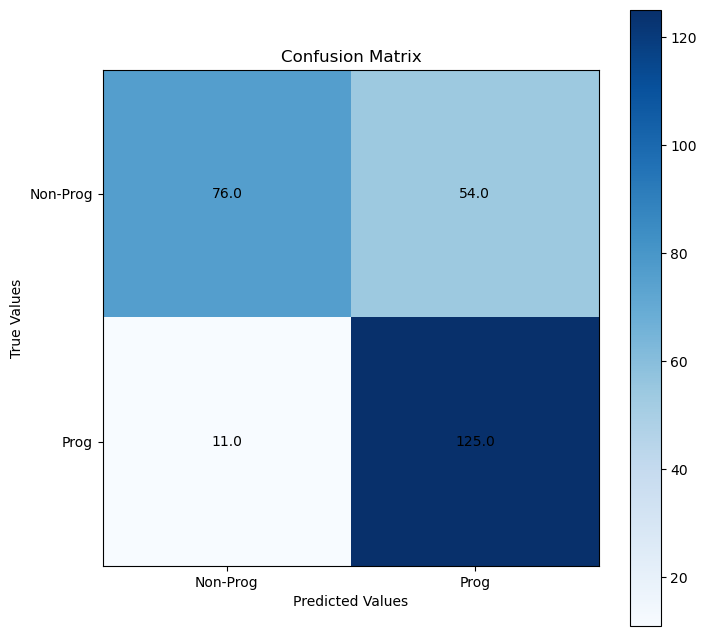

In [13]:
val_accuracy, val_loss, results, table = rec.evaluate_rnn(list(test_dict.keys()), test_songs_probabilities, test_labels, rnn, criterion, device)
generate_table(f"rnn_eval_exp{EXPERIMENT}", table)
Utils.getClassAccuracies(result, CLASS_NAMES)
Utils.plot_confusion_matrix(result["conf_matrix"], CLASS_NAMES)

### LSTM Over Songs

In [14]:
HIDDEN_SIZE = 5
NUM_LAYERS = 1
NUM_CLASSES = 1
lstm = rec.MyLSTM(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, num_classes=NUM_CLASSES).to(device)
lstm_params = torch.load(f"models/lstm_exp{EXPERIMENT}.pth")
lstm.load_state_dict(lstm_params["model_state_dict"])
criterion = nn.BCELoss()
model_name = 'lstm'

1)	03 Nightmares On Wax - Pipes Honour.mp3	 1:0	0.68
2)	Barclay James Harvest - Mocking Bird.mp3	 0:1	0.03
3)	05 Awaken.mp3	 0:1	0.07
4)	MIKE OLDFIELD - Part One (Ommadawn).mp3	 0:1	0.0
5)	Thrak-King Crimson-06-THRAK.mp3	 0:1	0.0
6)	01 - Nothing At Best.mp3	 0:1	0.0
7)	07 - The Final Thing On My Mind.mp3	 0:1	0.15
8)	08 Suite Sister Mary.mp3	 0:1	0.04
9)	01. Ka$cade.mp3	 0:1	0.0
10)	02_Freewill.mp3	 0:1	0.03
11)	01 - Atom Heart Mother Suite (2011 - Remaster).mp3	 0:1	0.14
12)	08_-_shadow_of_the_hierophant_320_lame_cbr.mp3	 0:1	0.0
13)	05_Turn of the Century.mp3	 0:1	0.49
14)	The Gathering - 09 - Saturnine.mp3	 0:1	0.16
15)	03 - Kali Yuga.mp3	 0:1	0.04
16)	The Power To Believe-King Crimson-08-Dangerous Curves.mp3	 0:1	0.09
17)	10 Peace To The Mountain.mp3	 0:1	0.0
18)	03-Birthday.mp3	 1:0	0.58
19)	De-Loused In The Comatorium-The Mars Volta-07-Cicatriz ESP.mp3	 0:1	0.0
20)	Rick Wakeman-The Six Wives of Henry VIII-05-Anne Boleyn 'The Day Thou Gavest Lord Hath Ended'.flac	 0:1	0.28
21)	06-

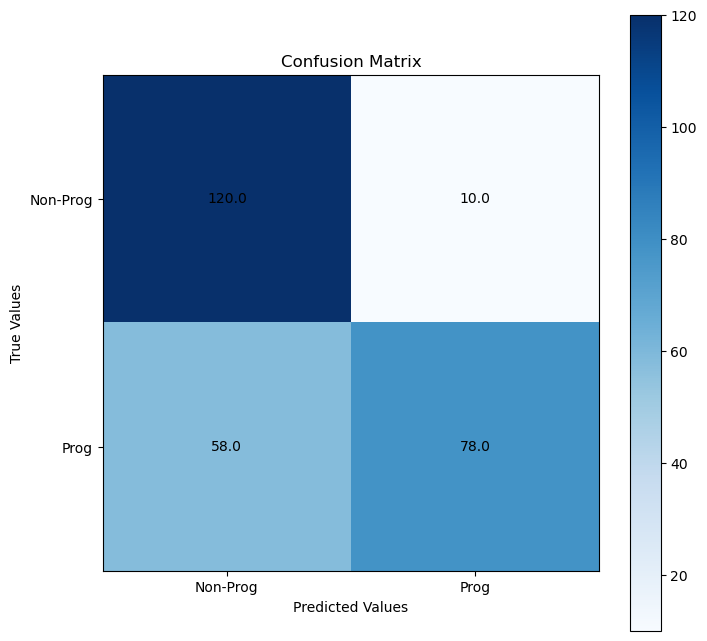

In [15]:
validate_songs_probabilities, validate_labels = rec.prepareSongData(test_dict, test_songs, model=model_name)
val_accuracy, val_loss, results, table = rec.evaluate_lstm(list(test_dict.keys()), validate_songs_probabilities, validate_labels, lstm, criterion, device)
generate_table(f"lstm_eval_exp{EXPERIMENT}", table)
Utils.getClassAccuracies(result, CLASS_NAMES)
Utils.plot_confusion_matrix(results['conf_matrix'], CLASS_NAMES)

## Post Prog Rock

### Loading data

In [16]:
other_songs = [(i, Utils.getName(i), 1) for i in librosa.util.find_files("Other/")]
dataset_2 = SnippetProgDataset(other_songs, transform=transform)

  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


### Evaluate Models

In [17]:
loader2 = DataLoader(dataset_2, batch_size = BATCH_SIZE, num_workers = 2, shuffle = True)
other_dict = eval_score(loader2, model)

In [18]:
other_songs_probabilities, _ = rec.prepareSongData(other_dict, other_songs)
with torch.no_grad():
    for idx, (name, song) in enumerate(zip(other_dict.keys(), other_songs_probabilities)):
        score = torch.mean(song.view(-1))
        print(f"{idx}\t{name}\t{score:.2f}")

0	Textures - Laments Of An Icarus.mp3	0.64
1	01-darko_us-splinter_cell.mp3	0.48
2	AFTER THE BURIAL - A Wolf Amongst Ravens.mp3	0.60
3	Meshuggah- Soul Burn.mp3	0.38
4	06 A Light Will Shine.mp3	0.81
5	06-1289, Voyeur Will Shine, Fight For Distinction, Evolution Is Mine..mp3	0.49
6	01 Arithmophobia.mp3	0.83
7	03 - Language II Conspire.mp3	0.89
8	SikTh - Hold My Finger.mp3	0.49
9	The Algorithm - Isometry.mp3	0.14
10	MONUMENTS - I, The Creator.mp3	0.72
11	CHIMP SPANNER - Bad Code.mp3	0.78
12	07 The Race Is About To Begin.mp3	0.67
13	Veil Of Maya - Punisher.mp3	0.63
14	b1-master_boot_record-dma_4_cascade.mp3	0.29
15	HEART OF A COWARD - Hollow.mp3	0.09
16	BORN OF OSIRIS - Divergency.mp3	0.18
17	08-the_haarp_machine-machine_over.mp3	0.98
18	Cloudkicker - Let yourself be huge.mp3	0.85
19	05. Physical Education.mp3	0.53
20	PERIPHERY - Zyglrox.mp3	0.77
21	Hacktivist - DECEIVE AND DEFY.mp3	0.39


In [20]:
rec.eval_score_rnn(list(other_dict.keys()), other_songs_probabilities, rnn, device)

0	Textures - Laments Of An Icarus.mp3	0.02
1	01-darko_us-splinter_cell.mp3	0.00
2	AFTER THE BURIAL - A Wolf Amongst Ravens.mp3	0.00
3	Meshuggah- Soul Burn.mp3	0.00
4	06 A Light Will Shine.mp3	0.63
5	06-1289, Voyeur Will Shine, Fight For Distinction, Evolution Is Mine..mp3	0.00
6	01 Arithmophobia.mp3	0.88
7	03 - Language II Conspire.mp3	0.93
8	SikTh - Hold My Finger.mp3	0.00
9	The Algorithm - Isometry.mp3	0.00
10	MONUMENTS - I, The Creator.mp3	0.14
11	CHIMP SPANNER - Bad Code.mp3	0.55
12	07 The Race Is About To Begin.mp3	0.01
13	Veil Of Maya - Punisher.mp3	0.06
14	b1-master_boot_record-dma_4_cascade.mp3	0.00
15	HEART OF A COWARD - Hollow.mp3	0.00
16	BORN OF OSIRIS - Divergency.mp3	0.00
17	08-the_haarp_machine-machine_over.mp3	1.00
18	Cloudkicker - Let yourself be huge.mp3	0.83
19	05. Physical Education.mp3	0.00
20	PERIPHERY - Zyglrox.mp3	0.49
21	Hacktivist - DECEIVE AND DEFY.mp3	0.00
